# NX_transformations for PEEM

The interpretation of PEEM data requires the full knowledge of the direction, energy and polarisation state of the incoming excitation beam in the sample coordinate. The incoming excitation, in the following, is considered to be photon (X-rays, UV, laser) but the same considerations can be done for other source, as spin polarised electron gun or ion beams, that can carry a spin polarisation. 

The sample manipulator of most of the PEEMs has also a translation $(x_s,y_s)$ stage to navigate the sample surface, a biaxial tilt adjustment, for alignment purpose, and an azimutal ($\chi_s$) sample rotation stage, to change the in-plane incident direction of the incoming beam. The electron image of the sample is subjected to a further rotation while travelling throught the PEEM optics ($\alpha$) that will be called PEEM Field Of View (FOV) rotation. 

The Nexus transformations can be used to describe the changes of coordinates. The beam $\leftrightarrow$ sample is a 3d rotation dependent on the (fixed) PEEM and light source geometry and on the variable $\chi$ rotation angle; the sample $\leftrightarrow$ detector is a 2d rotation depending on $\alpha$ (lenses excitation/image magnification) and $\chi_s$ rotation. The mapping of detector pixels onto the sample requires the knowledge of the manipulator translation $(x_s,y_s)$ encoders and microscope magnification (FOV). 

The light propagation and polarisation vectors in sample coordinates could be stored in the Nexus file, however the light polarisation is usually known in the light (or laboratory) coordinates. It is preferable to store the transformation from light to sample as a Nexus_transformation field, instead, because it is a method that can be applied to any microscope geometry. The transformation matrix must be defined only once for the particular microscope being used. 


Storing the transformation seems to be the preferred strategy for Nexus files:
"In the recommended way of dealing with geometry NeXus uses a series of transformations  to place objects in space. In this world view, the absolute position of a component or a detector pixel with respect to the laboratory coordinate system is calculated by applying a series of translations and rotations. Thus a rotation or translation operation transforms the whole coordinate system and gives rise to a new local coordinate system."
https://manual.nexusformat.org/design.html#the-nexus-coordinate-system


In the following we will make a case study out of the i06 AC-PEEM.

## Reference systems

As a case study, the geometry of the i06 AC-PEEM and its X-ray optics is as follows:

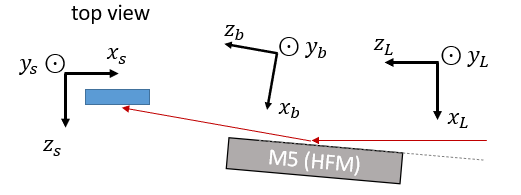


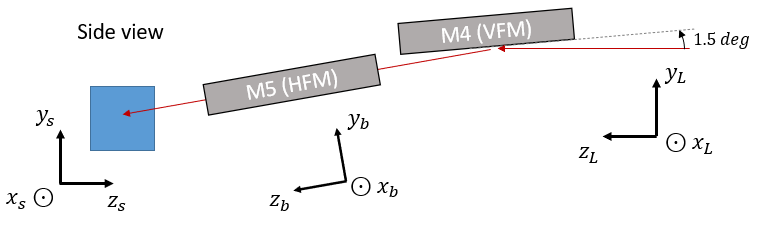

The PEEM and its illumination source can be describedby with four reference systems: 

$O_L$ = laboratory 
$O_b$ = incoming beam
$O_s$ = sample 
$O_d$ = detector

The light polarisation is easily defined, through the stokes parameters. As proposed by Steve Collins (DLS), a suitable coordinate system for the incident beam on the sample consistent with the DLS/NeXus coordinates can be defined as having the $\times\hat{\mathbf{z}}$ along the propagation direction. The $\times\hat{\mathbf{x}}$ can be arbitrarily oriented along the horizontal direction:

$\mathbf{\hat{z}}$ = beam direction

$\mathbf{\hat{v}}$ = vertical vector

$$
\mathbf{\hat{x}} = \mathbf{\hat{v}} \times \hat{\mathbf{z}}
$$ 

This appears to be consistent with the polarization definitions in NeXus (NXbeam):
https://manual.nexusformat.org/classes/base_classes/NXbeam.html?highlight=nxbeam
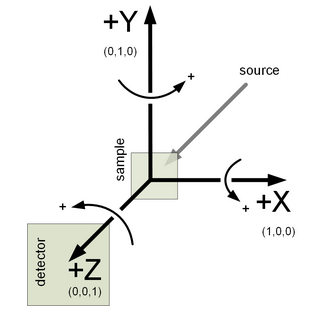
and Wikipedia:
https://en.wikipedia.org/wiki/Stokes_parameters

The $O_s$ sample reference system can be defined as
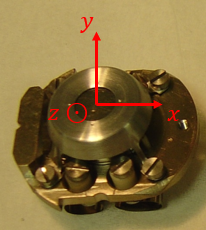
where $\chi_s$ rotation is right-handed along $z$. 

The $O_d$ detector is the reference of the raw image, where the $O_s$ is rotated by $\alpha$, as visible in the  panel (a) below.
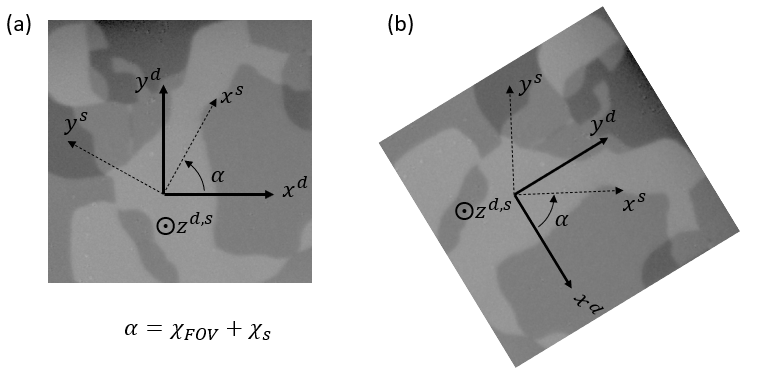

The raw detector image can be rotated by $\alpha$ to align the sample reference $O_s$ horizontally, which make the sample navigation and the data analysis very easier: it is worth reminding that the light momentum and polarisation vector have been described by a Nexus transformation.

From the nexus documentation:
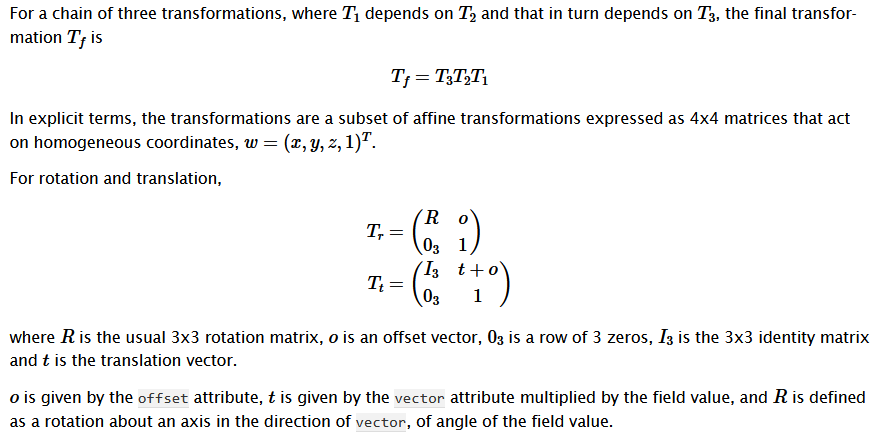

In the following we will calculate the rotation matrix $\mathbf{R}$ for the i06 AC-PEEM, extract the rotation vector as the eingenvector of $\mathbf{R}$ and the rotation angle from the matrix trace as
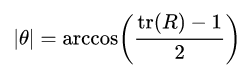

We will split the rotation in a chain of two NX-transformations
(a) rotate the $O_b$ to the un-rotated sample stage $O_s$
(b) rotate the $O_s$ by $\phi$

The NX-transformations are not defined with the vector/angle notation: we will then calculate the rotation vector axis/angle for the first step (the second step is simply an $\mathbf{R_x}$ rotation). 

In [74]:
import numpy as np
from sympy import *
from IPython.display import display, Markdown

init_printing(use_unicode=True)

chi, alpha, beta, gamma = symbols('chi alpha beta gamma')
#rotation matrixes along main axes
#the x-rotation will be the chi sample manipulator rotation
Rx = Matrix([[1,0,0],[0, cos(chi), sin(chi)],[0, -sin(chi), cos(chi)]])
Ry = Matrix([[cos(beta), 0, -sin(beta)],[0, 1,0], [sin(beta), 0, cos(beta)]])
Rz = Matrix([ [cos(gamma), sin(gamma), 0], [-sin(gamma), cos(gamma), 0], [0, 0, 1]])

#R = Rz*Ry*Rx
display(Markdown('Individual rotation matrixes:'))
display(Markdown('$R_x = $'), Rx)
display(Markdown('$R_y = $'), Ry)
display(Markdown('$R_z = $'), Rz)
#display(Markdown('$R = R_x * R_y * R_z = $'), R)



display(Markdown('The first rotation depends on the geometry of the microscope and of the incoming beam:'))
R1 = Rz*Ry
display(Markdown('$R_1(\bbeta,\gamma) = R_z * R_y = $'), R1)
display(Markdown('With $\bbeta = 90^{\circ}+16^{\circ}$ and $\gamma = 3^{\circ}$'))
R1_comp = R1.subs([(beta, 106/180*pi), (gamma, -3/180*pi)]).evalf(3)

display(Markdown('$R_{1comp} = R_z * R_y = $'), R1_comp)
R1_eigen = R1_comp.eigenvects()
#display(Markdown('$R_{1comp}$ eigenvectors/eigenvalues'), R1_eigen)
#the axis eigenvector is the one with eigenvalue=1
eigenVect = R1_eigen[0][2]

display(Markdown('Rotation axis vector of $R_1$:'))
display(eigenVect)
display(Markdown('note: this vector should be real, according to the theory...I do not understand where is the error...'))
#see https://en.wikipedia.org/wiki/Rotation_matrix'
display(Markdown('I do not understand where is the error.....'))

trace = float(R1_comp.trace())
R1_ang = np.arccos((trace-1.0)/2)/np.pi*180

display(Markdown('Rotation angle of $R_1$:'+str(R1_ang)+'$^\circ$'))

display(Markdown('The second rotation is simply the $\chi$ rotation of the manipulator:'))
R2 = Rx
display(Markdown('$R_2=R_x(\chi)=$'), R2)
display(Markdown('The rotation axis and rotation magnitude of $R_2$ are simply $\mathbf{\hat{x}}$ and $\mathbf{\chi_s}$'))





Individual rotation matrixes:

$R_x = $

⎡1     0       0   ⎤
⎢                  ⎥
⎢0  cos(χ)   sin(χ)⎥
⎢                  ⎥
⎣0  -sin(χ)  cos(χ)⎦

$R_y = $

⎡cos(β)  0  -sin(β)⎤
⎢                  ⎥
⎢  0     1     0   ⎥
⎢                  ⎥
⎣sin(β)  0  cos(β) ⎦

$R_z = $

⎡cos(γ)   sin(γ)  0⎤
⎢                  ⎥
⎢-sin(γ)  cos(γ)  0⎥
⎢                  ⎥
⎣   0       0     1⎦

The first rotation depends on the geometry of the microscope and of the incoming beam:

$R_1(beta,\gamma) = R_z * R_y = $

⎡cos(β)⋅cos(γ)   sin(γ)  -sin(β)⋅cos(γ)⎤
⎢                                      ⎥
⎢-sin(γ)⋅cos(β)  cos(γ)  sin(β)⋅sin(γ) ⎥
⎢                                      ⎥
⎣    sin(β)        0         cos(β)    ⎦

With $beta = 90^{\circ}+16^{\circ}$ and $\gamma = 3^{\circ}$

$R_{1comp} = R_z * R_y = $

⎡-0.275   -0.0523   -0.96 ⎤
⎢                         ⎥
⎢-0.0144   0.999   -0.0503⎥
⎢                         ⎥
⎣ 0.961      0     -0.276 ⎦

Rotation axis vector of $R_1$:

⎡⎡0.0209057746889985 - 0.015745262804426⋅ⅈ ⎤⎤
⎢⎢                                         ⎥⎥
⎢⎢ -0.79836012505762 + 0.60128792970402⋅ⅈ  ⎥⎥
⎢⎢                                         ⎥⎥
⎣⎣0.0157540096991789 - 0.0118651916337538⋅ⅈ⎦⎦

note: this vector should be real, according to the theory...I do not understand where is the error...

I do not understand where is the error.....

Rotation angle of $R_1$:106.02895160106625$^\circ$

The second rotation is simply the $\chi$ rotation of the manipulator:

$R_2=R_x(\chi)=$

⎡1     0       0   ⎤
⎢                  ⎥
⎢0  cos(χ)   sin(χ)⎥
⎢                  ⎥
⎣0  -sin(χ)  cos(χ)⎦

The rotation axis and rotation magnitude of $R_2$ are simply $\mathbf{\hat{x}}$ and $\mathbf{\chi_s}$

## sample stage translations

The sample translation stage is usually mounted on top of the $\chi$ rotation stage, with the rotation center aligned (approximatively...) to the center of FOV. After rotating the detector image by $\alpha = \chi_{s} + \chi_{FOV}$ the mapping of the detector pixel on the sample is therefore given by a simple linear relation. We can define the coordinates of the central pixel of the detector as the sample stage motor encoders values $(x_s, y_s)$.
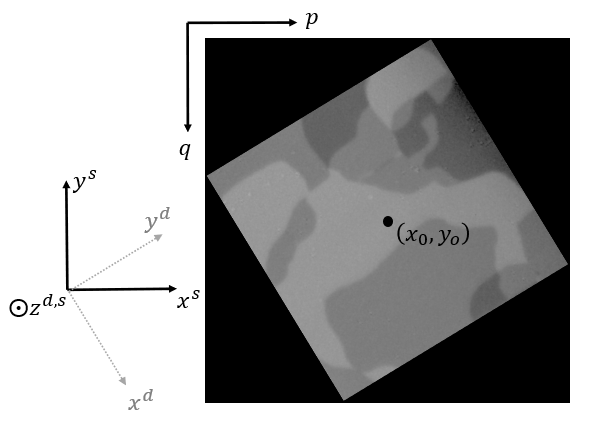


$$
\mathbf{\varepsilon}^T J \mathbf{\varepsilon}
$$

By defining

$L =$ FOV length 

$n =$ image pixel size

$(p,q)=$ image pixel coordinates

$(x_0,y_0)=$ sample stage position

the mapping of sample coordinates on the pixel is:

$x(p) = -x_0 - \frac{L}{2}+\frac{L}{n}p$

$y(q) = -y_0 + \frac{L}{2}-\frac{L}{n}q$

To my best knowledge the NX_transformations are not suitable for this specific linear mapping, but the x/y field of NX_data can be used instead. 